# Week 1. APIs

## Today's objectives

1. Understand different ways to access data via an API
2. Introduce the `requests` library 
3. Learn how to parse JSON data
4. Pratice with `pandas`, `geopandas`, and plotting


One way to get data is to download it manually from a website. You might click through a series of links and then save a `.csv` or similar file to your hard drive.

Another way is through an Application Programming Interface (API). These APIs make it possible to request just the data that you are interested in. Sometimes, this data is static—it will be the same each time you request it. The U.S. Census is a good example. Other APIs are dynamic—for example, bus arrival times.

## Example: Los Angeles Metro
Many APIs return a format known as JSON. While it seems complicated, it's relatively easy to work with because it's highly structured.

Metro provides its [API documentation here](https://developer.metro.net/api/). Click through the examples at the end and see what the result looks like.

How do we get this into Python? The `requests` library is the key to unlocking many interactions with the web.

In [1]:
import requests
r = requests.get('https://api.metro.net/agencies/lametro/stops/10988/predictions/')

Here, we've made a request to the Metro API, and stored the response in the `r` object. Stop ID 10988 is outside the Public Affairs Building. ([I looked that up on Google Maps.](https://goo.gl/maps/Y4wyVriw1AhyDtxB6))

Let's see what the `r` object includes. Use `r.` and the `tab` autocomplete in Jupyter Notebook.

In [2]:
# this line is specific to my Python environment, so you can ignore it
%config Completer.use_jedi = False

print(r.ok)

True


In [3]:
# This should give you the same information as if you used a web browser to go to the same link
print(r.text)

{"items": [{"route_id": "2", "block_id": "0020600", "run_id": "2_1057_1", "is_departing": false, "minutes": 0.0, "seconds": 37.0, "trip_id": "52266822"}, {"route_id": "2", "block_id": "0020400", "run_id": "2_1057_1", "is_departing": false, "minutes": 14.0, "seconds": 864.0, "trip_id": "52266819"}, {"route_id": "2", "block_id": "0025200", "run_id": "2_1057_1", "is_departing": false, "minutes": 32.0, "seconds": 1923.0, "trip_id": "52266817"}, {"route_id": "2", "block_id": "0025300", "run_id": "2_1057_1", "is_departing": false, "minutes": 49.0, "seconds": 2946.0, "trip_id": "52266740"}, {"route_id": "2", "block_id": "0020902", "run_id": "2_1057_1", "is_departing": false, "minutes": 61.0, "seconds": 3718.0, "trip_id": "52266770"}]}



So how can we get this into a more usable form? The `json` module is the key. It's built-in to Python so you don't have to install anything.

In [4]:
import json

In [5]:
# json.loads() will turn the JSON object into a dictionary
d = json.loads(r.text)
print(type(d))

<class 'dict'>


In [6]:
# remember, a dictionary is a collection of keys and values
# here looks like there is one key, called items
print(d.keys())
print(d['items'])

dict_keys(['items'])
[{'route_id': '2', 'block_id': '0020600', 'run_id': '2_1057_1', 'is_departing': False, 'minutes': 0.0, 'seconds': 37.0, 'trip_id': '52266822'}, {'route_id': '2', 'block_id': '0020400', 'run_id': '2_1057_1', 'is_departing': False, 'minutes': 14.0, 'seconds': 864.0, 'trip_id': '52266819'}, {'route_id': '2', 'block_id': '0025200', 'run_id': '2_1057_1', 'is_departing': False, 'minutes': 32.0, 'seconds': 1923.0, 'trip_id': '52266817'}, {'route_id': '2', 'block_id': '0025300', 'run_id': '2_1057_1', 'is_departing': False, 'minutes': 49.0, 'seconds': 2946.0, 'trip_id': '52266740'}, {'route_id': '2', 'block_id': '0020902', 'run_id': '2_1057_1', 'is_departing': False, 'minutes': 61.0, 'seconds': 3718.0, 'trip_id': '52266770'}]


In [7]:
# and in turn, 'items' is a list. You could also have seen this because of the square brackets [ ]  
print(type(d['items']))

# let's look at the first element of the list
item1 = d['items'][0]  
print(item1)

<class 'list'>
{'route_id': '2', 'block_id': '0020600', 'run_id': '2_1057_1', 'is_departing': False, 'minutes': 0.0, 'seconds': 37.0, 'trip_id': '52266822'}


It's another dictionary!

Question: How would you print the route number and arrival time for this bus?
What about all the buses shortly arriving at this stop?

In [8]:
# Here, we use the .format() method for a string. We insert the items in the .format() part into the curly braces {}
print('Route {} is arriving in {} minutes'.format(item1['route_id'], item1['minutes']))

# Run all the cells again and watch the arrival times change

Route 2 is arriving in 0.0 minutes


In [9]:
for bus in d['items']:
    print('Route {} is arriving in {:.0f} minutes'.format(bus['route_id'], bus['minutes']))

Route 2 is arriving in 0 minutes
Route 2 is arriving in 14 minutes
Route 2 is arriving in 32 minutes
Route 2 is arriving in 49 minutes
Route 2 is arriving in 61 minutes


In [10]:
# To make this easier to work with, we can convert to a pandas DataFrame
# pandas understands lists of dictionaries

import pandas as pd
df = pd.DataFrame(d['items'])
df

,route_id,block_id,run_id,is_departing,minutes,seconds,trip_id
0,2,0020600,2_1057_1,False,0.0,37.0,52266822
1,2,0020400,2_1057_1,False,14.0,864.0,52266819
2,2,0025200,2_1057_1,False,32.0,1923.0,52266817
3,2,0025300,2_1057_1,False,49.0,2946.0,52266740
4,2,0020902,2_1057_1,False,61.0,3718.0,52266770


<div class="alert alert-block alert-info">
<strong>Exercise:</strong> How would you calculate the mean headway (time between buses)?</div>

Now, let's generalize. The API above takes a string of a particular form. So we can write a function that gets the times for any bus stop. All we are doing here is taking the code above, putting it into a function, and making the stop id an argument to that function.

In [11]:
def getArrivalTimes(stopId):
    """Returns a dataframe of arrival times for a given stop id"""
    # Note the use of the format here to insert the id into the string
    url = 'https://api.metro.net/agencies/lametro/stops/{}/predictions/'.format(stopId)
    r = requests.get(url)
    d = json.loads(r.text)
    df = pd.DataFrame(d['items'])
    return df

getArrivalTimes(10988)

,route_id,block_id,run_id,is_departing,minutes,seconds,trip_id
0,2,0020600,2_1057_1,False,0.0,45.0,52266822
1,2,0020400,2_1057_1,False,13.0,824.0,52266819
2,2,0025200,2_1057_1,False,31.0,1900.0,52266817
3,2,0025300,2_1057_1,False,48.0,2893.0,52266740
4,2,0020902,2_1057_1,False,61.0,3683.0,52266770


<div class="alert alert-block alert-info">
<strong>Exercise:</strong> Explore some of Metro's other API collections at the same link above
</div>

## Example: US Census
Traditionally, if you wanted census data, you had to download .csv or other files and decipher them. Recently, the census has introduced an API. [See the documentation here](https://www.census.gov/data/developers/guidance/api-user-guide.Example_API_Queries.html).

If you request more than 500 queries a day, you'll need to register for a (free) [API key](https://www.census.gov/data/developers/guidance/api-user-guide.Help_&_Contact_Us.html) from the Census Bureau.

Let's download population by county from the 2019 American Community Survey one-year estimates. We see from the documentation that the API call takes the following form:

`https://api.census.gov/data/YEAR/acs/DATASET/?get=TABLENAME&for=GEOGRAPHY`

So getting the population (table `B00001_001E`) for all counties is:

`https://api.census.gov/data/2014/acs/acs5/?get=B00001_001E&for=county`

Try this in your browser.

Now let's get it into Python.

In [12]:
r = requests.get('https://api.census.gov/data/2014/acs/acs5/?get=B00001_001E&for=county')
type(r.text)
# This time, it looks like the data come in a string

str

In [13]:
# But turns out that it's actually a non-standard JSON.
censusdata = r.json()
type(censusdata)

list

In [14]:
# In fact, it's a list of lists. The first sublist is the column headers
censusdata[:5] # show the first five rows

[['B00001_001E', 'state', 'county'],
 ['139', '31', '117'],
 ['1583', '31', '033'],
 ['2880', '31', '047'],
 ['384', '31', '071']]

In [15]:
# So we can also convert this to a pandas dataframe, if we use the first list as the column names
# Note that the state and county are shown by their FIPS codes
pd.DataFrame(censusdata[1:], columns=censusdata[0])

,B00001_001E,state,county
0,139,31,117
1,1583,31,033
2,2880,31,047
3,384,31,071
4,830,31,125
...,...,...,...
3215,2293,28,029
3216,17029,28,049
3217,2145,28,145
3218,1789,28,139


<div class="alert alert-block alert-info">
<strong>Exercise:</strong> Can you write a function that retrieves the population for a given year and geography type?
</div>

### Using cenpy
It turns out that there is an easier way to get the census data. Rather than using the Census API, we can call it through the `cenpy` package.

In [16]:
import cenpy
from cenpy import products
import matplotlib.pyplot as plt
# this makes sure that plots appear in the same window
%matplotlib inline  

# create a connection to the American Community Survey
acs = cenpy.products.ACS()


In [17]:
# what tables are available?
acs.tables

,description,columns
table_name,,
B00001,UNWEIGHTED SAMPLE COUNT OF THE POPULATION,[B00001_001E]
B00002,UNWEIGHTED SAMPLE HOUSING UNITS,[B00002_001E]
B01001,SEX BY AGE,"[B01001_001E, B01001_002E, B01001_003E, B01001..."
B01002,MEDIAN AGE BY SEX,"[B01002_001E, B01002_002E, B01002_003E]"
B01003,TOTAL POPULATION,[B01003_001E]
...,...,...
C27014,PUBLIC HEALTH INSURANCE BY WORK EXPERIENCE,"[C27014_001E, C27014_002E, C27014_003E, C27014..."
C27016,HEALTH INSURANCE COVERAGE STATUS BY RATIO OF I...,"[C27016_001E, C27016_002E, C27016_003E, C27016..."
C27017,PRIVATE HEALTH INSURANCE BY RATIO OF INCOME TO...,"[C27017_001E, C27017_002E, C27017_003E, C27017..."


In [18]:
# Let's map the age of the housing stock
acs.filter_tables('BUILT', by='description')

,description,columns
table_name,,
B25034,YEAR STRUCTURE BUILT,"[B25034_001E, B25034_002E, B25034_003E, B25034..."
B25035,MEDIAN YEAR STRUCTURE BUILT,[B25035_001E]
B25036,TENURE BY YEAR STRUCTURE BUILT,"[B25036_001E, B25036_002E, B25036_003E, B25036..."
B25037,MEDIAN YEAR STRUCTURE BUILT BY TENURE,"[B25037_001E, B25037_002E, B25037_003E]"
B25050,PLUMBING FACILITIES BY OCCUPANTS PER ROOM BY Y...,"[B25050_001E, B25050_002E, B25050_003E, B25050..."
B25107,MEDIAN VALUE BY YEAR STRUCTURE BUILT,"[B25107_001E, B25107_002E, B25107_003E, B25107..."
B25108,AGGREGATE VALUE (DOLLARS) BY YEAR STRUCTURE BUILT,"[B25108_001E, B25108_002E, B25108_003E, B25108..."
B25111,MEDIAN GROSS RENT BY YEAR STRUCTURE BUILT,"[B25111_001E, B25111_002E, B25111_003E, B25111..."
B25112,AGGREGATE GROSS RENT (DOLLARS) BY YEAR STRUCTU...,"[B25112_001E, B25112_002E, B25112_003E, B25112..."


In [19]:
# it looks like table B25035 and variable B25035_001E are promising, Let's see what is here in Riverside County
riverside = products.ACS(2017).from_county('Riverside, CA', level='tract',
                                        variables='B25035_001E')

/Users/adammb/anaconda3/envs/urbandatascience/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [20]:
# It looks like cenpy gives us a geopandas dataframe
type(riverside)

geopandas.geodataframe.GeoDataFrame

In [21]:
riverside.head()

,GEOID,geometry,B25035_001E,NAME,state,county,tract
0,06065041703,"POLYGON ((-13091036.530 4012838.430, -13090979...",1983.0,"Census Tract 417.03, Riverside County, California",06,065,041703
1,06065041704,"POLYGON ((-13089368.180 4011805.460, -13089366...",1966.0,"Census Tract 417.04, Riverside County, California",06,065,041704
2,06065041600,"POLYGON ((-13088279.590 4012061.140, -13088279...",1963.0,"Census Tract 416, Riverside County, California",06,065,041600
3,06065040812,"POLYGON ((-13087011.440 4019470.870, -13087010...",1968.0,"Census Tract 408.12, Riverside County, California",06,065,040812
4,06065040813,"POLYGON ((-13087079.460 4014823.100, -13087077...",1993.0,"Census Tract 408.13, Riverside County, California",06,065,040813


In [22]:
# let's rename the census column to something more memorable
riverside.rename(columns={'B25035_001E':'Median year built'}, inplace=True)

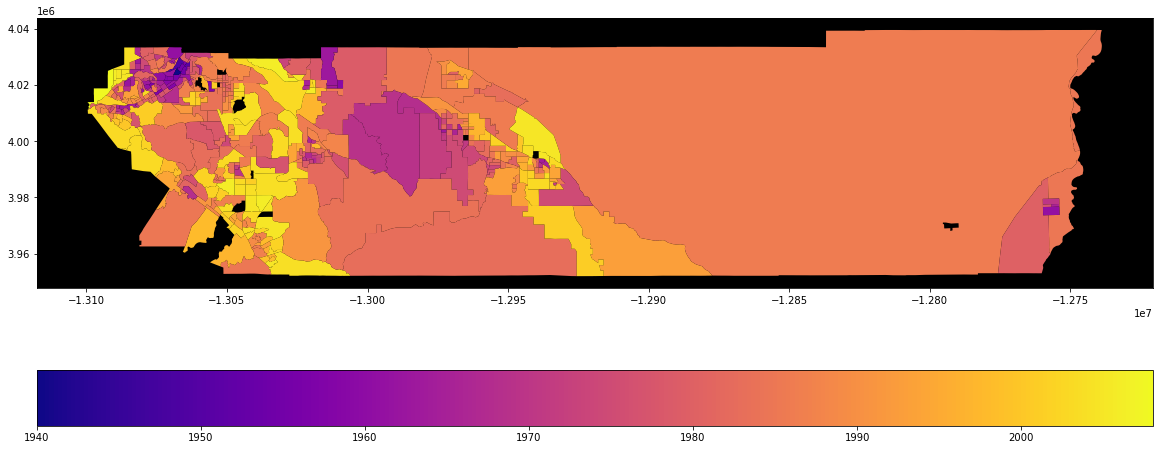

In [23]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
riverside.plot('Median year built', ax=ax, cmap='plasma', legend=True, 
               legend_kwds={'orientation': "horizontal"})
ax.set_facecolor('k')

### Socrata
If you took UP206A, you are probably familiar with the Socrata API. The City of Los Angeles is one user. [You can browse the city's datasets here](https://data.lacity.org).

Just like the census, you can call Socrata APIs with `requests`, but there is also a dedicated package.

[Look at the housing dataset here](https://data.lacity.org/Housing-and-Real-Estate/HCIDLA-Affordable-Housing-Projects-List-2003-to-Pr/mymu-zi3s). Click on the API button in the top right corner. You can see much useful information:

* The URL (the API endpoint)
* The format (JSON is the default)
* Some helpful links

In [24]:
url = 'https://data.lacity.org/resource/mymu-zi3s.json'
r = requests.get(url)
df = pd.DataFrame(json.loads(r.text))
df

,apn,project_number,name,development_stage,construction_type,address,council_district,site_cd,community,site_units,...,latitude,geocoded_column,:@computed_region_qz3q_ghft,:@computed_region_k96s_3jcv,:@computed_region_tatf_ua23,:@computed_region_ur2y_g4cx,:@computed_region_kqwf_mjcx,:@computed_region_2dna_qi2s,jobs,contract_numbers
0,5131020009,05-117217,LEXINGTON APARTMENTS A/B (SITE 11),In-Service,REHAB,"1145 E 24TH ST Los Angeles, CA 90011",9,11,CENTRAL,0,...,34.02133,"{'type': 'Point', 'coordinates': [-118.2556100...",22727,705,972,7,13,6,NaN,NaN
1,6071001013,06-117222,WINDWARD APTS (A/B) (SITE 14),In-Service,REHAB,"636 E 108TH ST 1-4 Los Angeles, CA 90059",8,14,CENTURY PALMS/COVE,8,...,33.93817,"{'type': 'Point', 'coordinates': [-118.26374, ...",24354,807,359,7,14,45,NaN,NaN
2,5544025033,60057,BRICKER,In-Service,ACQUISITION + REHAB,"1671 N WESTERN AVE Los Angeles, CA 90028",13,1,HOLLYWOOD,16,...,34.10127,"{'type': 'Point', 'coordinates': [-118.30957, ...",23446,420,608,16,8,57,14,{'url': 'https://hcidapp.lacity.org/citycontra...
3,5124011008,07-117233,HDR I & II (SITE 4),In-Service,REHAB,"2375 S SCARFF ST Los Angeles, CA 90007",1,4,UNIVERSITY PARK,20,...,34.03158,"{'type': 'Point', 'coordinates': [-118.2810599...",22724,698,444,7,11,32,NaN,NaN
4,5502020005,80050,ALEXANDRIA HOUSE APTS.,In-Service,REHAB,"510 S ALEXANDRIA AVE 1-20 Los Angeles, CA 90020",10,1,KOREATOWN,16,...,34.06506,"{'type': 'Point', 'coordinates': [-118.2977500...",23081,598,1316,NaN,12,89,36,{'url': 'https://hcidapp.lacity.org/citycontra...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,5082023002,19-125948,AMANI APARTMENTS (FKA PICO),Development,NEW CONSTRUCTION,"4200 W PICO BLVD Los Angeles, CA 90019",10,1,VICTORIA PARK,54,...,34.04741,"{'type': 'Point', 'coordinates': [-118.3271800...",23080,648,1345,NaN,12,69,287,{'url': 'https://hcidapp.lacity.org/citycontra...
501,4365008904,18-124750,BUILDING 205,Development,ACQUISITION + REHAB,"11301 WILSHIRE BLVD Los Angeles, CA 90073",11,1,NULL,68,...,34.0527,"{'type': 'Point', 'coordinates': [-118.4526384...",24036,2119,194,NaN,NaN,NaN,321,{'url': 'https://hcidapp.lacity.org/citycontra...
502,5501002033,14-121650,PATH METRO VILLAS PHASE I,In-Service,NEW CONSTRUCTION,"345 N WESTMORELAND AVE Los Angeles, CA 90004",13,1,SILVERLAKE,65,...,34.07753,"{'type': 'Point', 'coordinates': [-118.28811, ...",22721,455,507,16,8,80,188,{'url': 'https://hcidapp.lacity.org/citycontra...
503,5019023028,09-117207,STOVALL VILLAS,In-Service,NEW CONSTRUCTION,"4057 S FIGUEROA ST Los Angeles, CA 90037",9,1,WEST VERNON,32,...,34.01039,"{'type': 'Point', 'coordinates': [-118.2834099...",23668,735,977,7,13,2,85,{'url': 'https://hcidapp.lacity.org/citycontra...


We might have expected some geographic coordinates, and it looks like they are in the `geocoded_column` column.

But we converted it to a regular `pandas` DataFrame, which doesn't understand spatial relationships.

Let's try and put this in `geopandas`. Note that the complication arises because `geopandas` doesn't understand the format directly. We need to use the `shapely` library to convert the geometry column to a shapely shape. 

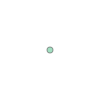

In [25]:
import geopandas as gpd
from shapely.geometry import shape

# let's look at one of the geometries and see if we can convert it
geom = df.loc[0,'geocoded_column']
shape(geom)

<AxesSubplot:>

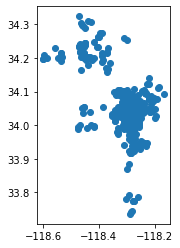

In [26]:
# Seems OK! Now let's use .apply to apply the shape function to that entire column, and put the results in a new column

df = gpd.GeoDataFrame(json.loads(r.text))
df['geom'] = df.geocoded_column.apply(shape) 
# now set that new column as our geometry. 4326 is the code for lat/long (i.e., unprojected data)
df.set_geometry('geom', crs=4326, inplace=True)  
df.plot()

Before we clean up the map, let's mention two others way to read that data in–using the Socrata API.

#### Sodapy

[That uses the `sodapy` library](https://pypi.org/project/sodapy/), which unfortunately isn't available in Anaconda. So we won't cover it here, but I bring it up because you may be familiar with it from UP206A.

If you want to use Socrata, you'll need to go to your command line (Terminal on the Mac or Command Prompt on Windows) and type:

`pip install sodapy`

`pip` is the standard Python package manager

#### Save to disk
You can always download the file to your computer, and load it in.

Socrata gives you [various options for the format for this file](https://data.lacity.org/Housing-and-Real-Estate/HCIDLA-Affordable-Housing-Projects-List-2003-to-Pr/mymu-zi3s): `csv`, `shp`, and so on. Let's use the shapefile version.

In [30]:
gpd.read_file('/Users/adammb/Desktop/HCIDLA Affordable Housing Projects List (2003 to Present)')

,address,apn,community,constructi,contact_ph,contract_l,contract_n,contract_2,contract_u,council_di,...,photo,project_nu,project_to,reporturl2,site_cd,site_units,supportive,tax_exempt,tdc,geometry
0,"1145 E 24TH ST Los Angeles, CA 90011",5.131020e+09,CENTRAL,REHAB,(323) 231-4174,None,None,None,None,9.0,...,click here (http://hcidapp.lacity.org/mpphotos...,05-117217,251.0,click here (http://hcidapp.lacity.org/ahtfRepo...,11.0,0.0,No,10247566.0,17019285.0,POINT (-118.25561 34.02133)
1,"636 E 108TH ST 1-4 Los Angeles, CA 90059",6.071001e+09,CENTURY PALMS/COVE,REHAB,(323) 231-4174,None,None,None,None,8.0,...,click here (http://hcidapp.lacity.org/mpphotos...,06-117222,232.0,click here (http://hcidapp.lacity.org/ahtfRepo...,14.0,8.0,No,4641342.0,12079815.0,POINT (-118.26374 33.93817)
2,"1671 N WESTERN AVE Los Angeles, CA 90028",5.544025e+09,HOLLYWOOD,ACQUISITION + REHAB,(714) 553-3450,"<a href=""https://hcidapp.lacity.org/citycontra...",C-111304,C-111304 (https://hcidapp.lacity.org/citycontr...,https://hcidapp.lacity.org/citycontractref/def...,13.0,...,click here (http://hcidapp.lacity.org/mpphotos...,60057,16.0,click here (http://hcidapp.lacity.org/ahtfRepo...,1.0,16.0,No,0.0,7093297.0,POINT (-118.30957 34.10127)
3,"2375 S SCARFF ST Los Angeles, CA 90007",5.124011e+09,UNIVERSITY PARK,REHAB,(818) 808-0600,None,None,None,None,1.0,...,click here (http://hcidapp.lacity.org/mpphotos...,07-117233,125.0,click here (http://hcidapp.lacity.org/ahtfRepo...,4.0,20.0,No,6787000.0,14903043.0,POINT (-118.28106 34.03158)
4,"510 S ALEXANDRIA AVE 1-20 Los Angeles, CA 90020",5.502020e+09,KOREATOWN,REHAB,(714) 533-3450,"<a href=""https://hcidapp.lacity.org/citycontra...",C-114811,C-114811 (https://hcidapp.lacity.org/citycontr...,https://hcidapp.lacity.org/citycontractref/def...,10.0,...,click here (http://hcidapp.lacity.org/mpphotos...,80050,16.0,click here (http://hcidapp.lacity.org/ahtfRepo...,1.0,16.0,Yes,0.0,6728306.0,POINT (-118.29775 34.06506)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,"4200 W PICO BLVD Los Angeles, CA 90019",5.082023e+09,VICTORIA PARK,NEW CONSTRUCTION,(858) 614-7376,"<a href=""https://hcidapp.lacity.org/citycontra...",C-137287,C-137287 (https://hcidapp.lacity.org/citycontr...,https://hcidapp.lacity.org/citycontractref/def...,10.0,...,click here (http://hcidapp.lacity.org/mpphotos...,19-125948,54.0,click here (http://hcidapp.lacity.org/ahtfRepo...,1.0,54.0,Yes,0.0,46812743.0,POINT (-118.32718 34.04741)
501,"11301 WILSHIRE BLVD Los Angeles, CA 90073",4.365009e+09,NULL,ACQUISITION + REHAB,(310) 576-1308,"<a href=""https://hcidapp.lacity.org/citycontra...",C-135751,C-135751 (https://hcidapp.lacity.org/citycontr...,https://hcidapp.lacity.org/citycontractref/def...,11.0,...,click here (http://hcidapp.lacity.org/mpphotos...,18-124750,68.0,click here (http://hcidapp.lacity.org/ahtfRepo...,1.0,68.0,Yes,8100000.0,42824387.0,POINT (-118.45264 34.05270)
502,"345 N WESTMORELAND AVE Los Angeles, CA 90004",5.501002e+09,SILVERLAKE,NEW CONSTRUCTION,(213) 787-2700,"<a href=""https://hcidapp.lacity.org/citycontra...",C-127914,C-127914 (https://hcidapp.lacity.org/citycontr...,https://hcidapp.lacity.org/citycontractref/def...,13.0,...,click here (http://hcidapp.lacity.org/mpphotos...,14-121650,65.0,click here (http://hcidapp.lacity.org/ahtfRepo...,1.0,65.0,Yes,1450000.0,28321688.0,POINT (-118.28811 34.07753)
503,"4057 S FIGUEROA ST Los Angeles, CA 90037",5.019023e+09,WEST VERNON,NEW CONSTRUCTION,(323) 231-1104,"<a href=""https://hcidapp.lacity.org/citycontra...",C-116059,C-116059 (https://hcidapp.lacity.org/citycontr...,https://hcidapp.lacity.org/citycontractref/def...,9.0,...,click here (http://hcidapp.lacity.org/mpphotos...,09-117207,32.0,click here (http://hcidapp.lacity.org/ahtfRepo...,1.0,32.0,No,0.0,9099042.0,POINT (-118.28341 34.01039)


Now let's clean up the map. First, note that we can call `df.plot()` directly, but we have more flexibility if we create our own figure and axis object and then pass that to the plot function. Normally, you create them both together using `plt.subplots()`.

Let's also plot a particular column, perhaps `site_units`, as a proportional circle.

[]

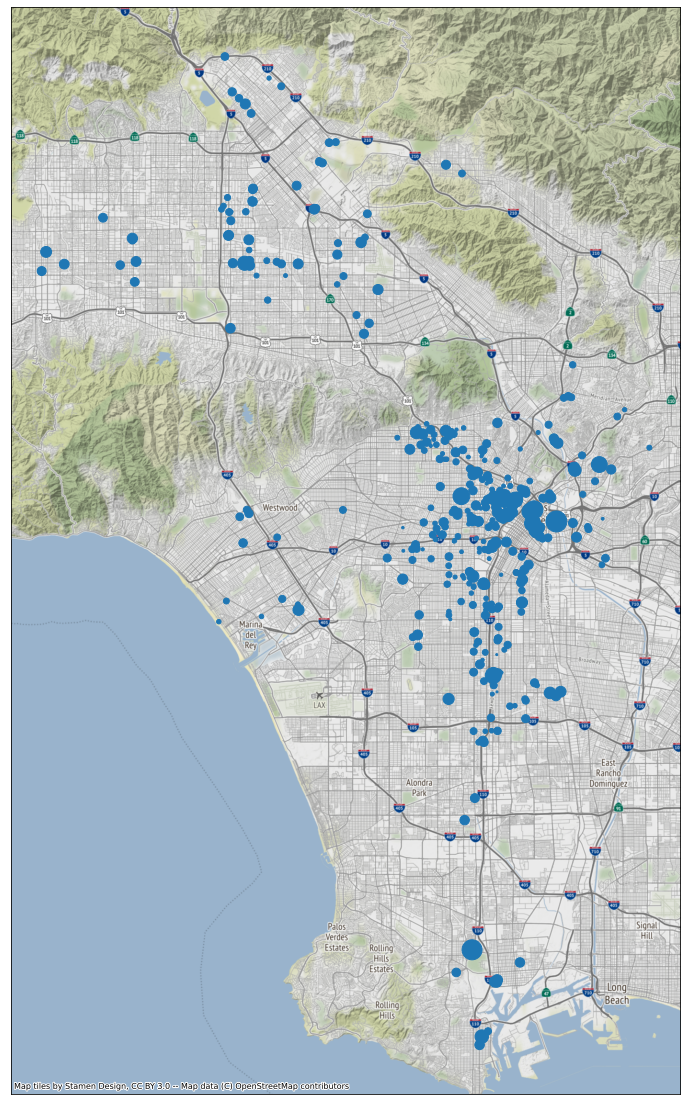

In [31]:
import matplotlib.pyplot as plt
import contextily as ctx
# If we try to plot site_units, we get an error due to the zero-unit entries. Let's solve that first.
df['site_units'] = df.site_units.astype(int)  # convert to integer

fig, ax = plt.subplots(figsize=(20,20))

# basemaps are typically in Web Mercator (projection 3857), so we need to reproject our dataframe to this
df[df.site_units>0].to_crs('EPSG:3857').plot(markersize='site_units', ax=ax)

# let's add a basemap using the contextily library
ctx.add_basemap(ax, zoom=12)

# and we really don't need the axis ticks and labels, so we set them to an empty list
ax.set_xticks([])
ax.set_yticks([])

<div class="alert alert-block alert-info">
<h3>Key Takeaways</h3>
<ul>
  <li>Many APIs are just URLs. You can compose the URL as a string.</li>
  <li>JSON is the typical format of the returned data, but you will often need to experiment.</li>
  <li>Be nice! Some APIs will ask you to register. Most will kick you off if you make too many requests.</li>
  <li>Some popular APIs have dedicated packages to make the process simpler.</li>
</ul>
</div>